# IA317: Large-scale machine learning
# Tree search

In this lab, you will learn to work with [kd-trees](https://en.wikipedia.org/wiki/K-d_tree), in particular to build the graph of nearest neighbors.<br>
You will find below a function to build a kd-tree and to find the nearest neighbor of some target using this data structure.

## Instructions

Please provide short answers to the questions at the bottom of the notebook. Most involve Python coding. Add as many cells as necessary (code and text). You might test your code using synthetic data.

Before uploading your notebook on [eCampus](https://ecampus.paris-saclay.fr/course/view.php?id=18426), please:
* Delete all useless cells (tests, etc.)
* Check that **your code is running and does not produce any errors**. You might restart the kernel and run all cells at the end of the lab to check that this is indeed the case. 
* Keep the outputs.

The deadline is **Thursday, December 18th (midnight).**

## Import

In [74]:
import numpy as np

In [75]:
from scipy import sparse

In [76]:
import matplotlib.pyplot as plt

In [77]:
import pandas as pd

In [78]:
import time

## Synthetic data

In [79]:
# Standard Gaussian model
X_synthetic = np.random.normal(size = (100,2))

## Real data

We will use a dataset providing the GPS coordinates of the ~13,000 largest cities of the world. For simplicity, we will use the Euclidean distance on the world map, with coordinates = (longitude, latitude).

In [80]:
# First download the file
cities = pd.read_csv('worldcities.csv')

In [81]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [82]:
names = list(cities['city'])
admin_names = list(cities['admin_name'])
lat = list(cities['lat'])
long = list(cities['lng'])

In [83]:
X = np.vstack((long,lat)).T

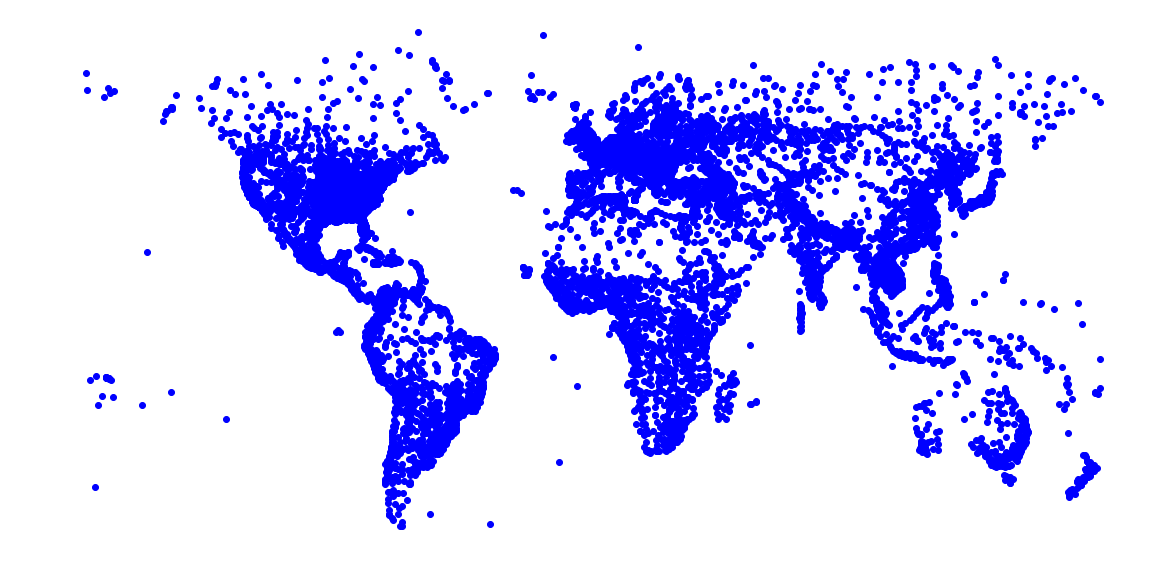

In [84]:
plt.figure(figsize = (20,10))
_ = plt.scatter(X[:,0], X[:,1], c='b')
_ = plt.axis('off')

## Kd trees

In [85]:
class KD_Tree:
    def __init__(self, index, ancestor, mins, maxs):
        self.index = index
        self.ancestor = ancestor
        self.mins = mins
        self.maxs = maxs
        self.direction = None        
        self.pivot = None
        self.left = None
        self.right = None

In [86]:
def split(X, index, method):
    '''Split method (max spread or max variance)
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray
        Sample indices, within range(n_samples)
    method : str, 'maxspread' or 'maxvariance'
        Method 
        
    Returns
    -------
    k : int
        Direction, in range(n_features)
    i : int
        Pivot, in range(n_samples)
    '''
    if method == 'maxspread':
        # max spread
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
        k = np.argmax(maxs - mins)
        middle = (maxs[k] + mins[k]) / 2
        i = index[np.argmin(np.abs(X[index,k] - middle))]
    else:
        # max variance
        k = np.argmax(np.std(X[index], axis = 0))
        i = index[np.argsort(X[index,k])[len(index) // 2]]
    return k, i

In [87]:
def build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread'):
    '''Build the kd-tree from data.
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray or None
        Sample indices, within range(n_samples)
    ancestor : KD_Tree or None
        Ancestor of the current node
    mins : np.ndarray or None
        Min values of the rectangle, shape (n_features,)
    maxs : np.ndarray
        Max values of the rectangle, shape (n_features,)
    leaf_size : int
        Leaf size of the kd-tree 
    method : str, 'maxspread' or 'maxvariance'
        Split method 
        
    Returns
    -------
    tree : KD_Tree
        kd-tree
    '''
    if index is None:
        index = np.arange(X.shape[0])
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
    tree = KD_Tree(index, ancestor, mins, maxs)
    if len(index) > leaf_size:
        k,i = split(X, index, method)
        tree.direction, tree.pivot = k, i
        index = np.array(list(set(index) - {i}))
        index_left = index[np.where(X[index,k] <= X[i,k])[0]]
        maxs_ = maxs.copy()
        maxs_[k] = X[i,k]
        tree.left = build_kd_tree(X, index_left, tree, mins, maxs_, leaf_size, method)
        index_right = index[np.where(X[index,k] > X[i,k])[0]]
        mins_ = mins.copy()
        mins_[k] = X[i,k]        
        tree.right = build_kd_tree(X, index_right, tree, mins_, maxs, leaf_size, method)
    return tree

In [88]:
def search_leaf(x, X, tree):
    '''Search the leaf node of the kd-tree given some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    tree : KD_Tree
        Leaf node
    '''
   
    if tree.pivot is not None:
        k = tree.direction
        i = tree.pivot
        if x[k] <= X[i,k]:
            return search_leaf(x, X, tree.left)
        else:
            return search_leaf(x, X, tree.right)
    else:
        return tree

In [89]:
def nn_search_kd_tree(x, X, tree):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    nn = None
    if len(index):
        nn = index[np.argmin(np.linalg.norm(X[index] - x, axis = 1))]
        dist = np.linalg.norm(X[nn] - x)
    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if nn is None or np.linalg.norm(X[node.pivot] - x) < dist:
            nn = node.pivot
            dist = np.linalg.norm(X[nn] - x)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                nn_ = nn_search_kd_tree(x, X, tree_)
                dist_ = np.linalg.norm(X[nn_] - x)
                if dist_ < dist:
                    nn, dist = nn_, dist_
                tree_.ancestor = ancestor
    return nn

## Questions

1. What is the closest city from the [Null Island](https://fr.wikipedia.org/wiki/Null_Island) (provide the name)?

In [90]:
then = time.time() 
list_dist_Q1 = []

for i in range (len(cities)):
    coord_i = np.array([cities['lat'][i],cities['lng'][i]])
    list_dist_Q1.append(np.linalg.norm(coord_i))
    
city = cities['city'][list_dist_Q1.index(min(list_dist_Q1))] 
now = time.time()

print("Closest city from the Null Island:",city)
print("Time to find the awnser in sec",now-then)

Closest city from the Null Island: Sekondi
Time to find the awnser in sec 0.2908017635345459


2. What are the 10 closest cities from Paris (provide the names)?<br>
Choose the true Paris :-)

In [91]:
then = time.time() 
cities_Q2 = cities.copy()
Paris_coord = np.array(cities[cities['city'].str.contains("Paris") & cities['country'].str.contains("France")][['lat','lng']])[0]
list_dist_Q2 = []
list_10_cities = []

for i in range (len(cities)):
    coord_i = np.array([cities['lat'][i],cities['lng'][i]])
    list_dist_Q2.append(np.linalg.norm(Paris_coord - coord_i))
    
cities_Q2['distance from paris'] = list_dist_Q2
cities_Q2.sort_values(by=['distance from paris'], inplace=True)
now = time.time()

print('The ten closest city to paris are:')
print(cities_Q2['city'][1:11])
print("Time to find the awnser in sec",now-then)

The ten closest city to paris are:
6768    Versailles
6769         Melun
6746        Amiens
6734       Orléans
6745         Rouen
6762         Arras
6765       Auxerre
6755        Dieppe
6752         Reims
6767       Bourges
Name: city, dtype: object
Time to find the awnser in sec 0.336519718170166


3. Compare the previous search time to a brute force approach (with default leaf size = 30).

In [92]:
# Brute force for question 1
X = np.vstack((lat,long)).T

then = time.time() 
tree_q3 = build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread')
id_1_q3 = nn_search_kd_tree(np.array([0,0]), X, tree_q3)

now = time.time()

print("Closest city from the Null Island:")
print(cities.iloc[[id_1_q3]]['city'])

print("Time to find the awnser in sec",now-then)

Closest city from the Null Island:
7065    Sekondi
Name: city, dtype: object
Time to find the awnser in sec 0.06918191909790039


This approach is almost 5 times faster for the first question.

In [112]:
# Brute force for question 2
then = time.time() 
cities_q3 = cities.copy()
Awnsers = []
Paris_coord = np.array(cities[cities['city'].str.contains("Paris") & cities['country'].str.contains("France")][['lat','lng']])[0]
X = np.vstack((lat,long)).T
Paris_id = 6735
X = np.delete(X,Paris_id,0)

tree_q3 = build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread')


city_names = cities['city']
city_names = city_names.tolist()
del city_names[Paris_id]

for t in range (10):
    id_2_q3 = nn_search_kd_tree(Paris_coord, X, tree_q3)
    Awnsers.append(city_names[id_2_q3])
    X = np.delete(X,id_2_q3,0)
    del city_names[id_2_q3]

    tree_q3 = build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread')

now = time.time()

print("10 closest city from Paris:")

print(Awnsers)

print("Time to find the awnser in sec",now-then)
    

10 closest city from Paris:
['Versailles', 'Melun', 'Amiens', 'Orléans', 'Rouen', 'Arras', 'Auxerre', 'Dieppe', 'Reims', 'Bourges']
Time to find the awnser in sec 0.6991806030273438


However this method is two times longer than the one we used in question 2 (since we have to rebuild the tree at each iteration). So based on what we want to do, brute force can be more or less effcient than a classical min/max method.

4. Do the same comparison for synthetic data (with $10^6$ samples for instance). Comment.

In [94]:
# Q1 with synthetic data

X_synthetic_q4 = np.random.normal(scale=(90,180) , size = (1000000,2))
then = time.time() 

list_dist_Q4 = []

for i in range (len(X_synthetic_q4)):
    coord_i = X_synthetic_q4[i]
    list_dist_Q4.append(np.linalg.norm(coord_i))

coord = X_synthetic_q4[list_dist_Q4.index(min(list_dist_Q4))] 
    
now = time.time()

print("Closest coord from the Null Island:")
print(coord)

print("Time to find the awnser in sec",now-then)


Closest coord from the Null Island:
[-0.02892093  0.08571826]
Time to find the awnser in sec 2.971362352371216


In [95]:
# Q1 with synthetic data and decision tre method
then = time.time() 

tree_q4_1 = build_kd_tree(X_synthetic_q4, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread')
id_1_q4_1 = nn_search_kd_tree(np.array([0,0]), X_synthetic_q4, tree_q4_1)

now = time.time()


print("Closest coord from the Null Island:")
print(X_synthetic_q4[id_1_q4_1])

print("Time to find the awnser in sec",now-then)

Closest coord from the Null Island:
[-0.02892093  0.08571826]
Time to find the awnser in sec 7.962250232696533


With synthetic data, the question one (The closest) become two times longer for the brute force approach

In [96]:
# Q2 with synthetic data


then = time.time() 
X_synthetic_q4_2 = X_synthetic_q4.copy()

Paris_coord = np.array(cities[cities['city'].str.contains("Paris") & cities['country'].str.contains("France")][['lat','lng']])[0]
list_dist_Q4 = []
list_10_coord = []

for i in range (len(X_synthetic_q4)):
    coord_i = X_synthetic_q4_2[i]
    list_dist_Q4.append(np.linalg.norm(Paris_coord - coord_i))

    
for i in range (10):
    list_10_coord.append(np.array([X_synthetic_q4_2[list_dist_Q4.index(min(list_dist_Q4))]]))
    X_synthetic_q4_2 = np.delete(X_synthetic_q4_2,list_dist_Q4.index(min(list_dist_Q4)),0)
    del list_dist_Q4[list_dist_Q4.index(min(list_dist_Q4))]

    
now = time.time()
  
print("10 closest coord from Paris:")

print(list_10_coord)

print("Time to find the awnser in sec",now-then)
    

10 closest coord from Paris:
[array([[49.02048635,  2.27900435]]), array([[48.67920708,  2.48503208]]), array([[48.63256472,  2.16766591]]), array([[48.52707809,  2.56468158]]), array([[48.68306887,  2.77561883]]), array([[49.34973002,  2.20904252]]), array([[49.14838221,  2.7522497 ]]), array([[49.02485077,  2.85035352]]), array([[49.23661637,  2.80793387]]), array([[49.4624445,  2.4660168]])]
Time to find the awnser in sec 4.908097505569458


In [97]:
# Q2 with synthetic data and brute force

then = time.time() 
Paris_coord = np.array(cities[cities['city'].str.contains("Paris") & cities['country'].str.contains("France")][['lat','lng']])[0]
list_10_coord = []
X_synthetic_q4_3 = X_synthetic_q4.copy()

tree_q4_2 = build_kd_tree(X_synthetic_q4_3, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread')


for t in range (10):
    id_q4 = nn_search_kd_tree(Paris_coord, X_synthetic_q4_3, tree_q4_2)
    list_10_coord.append(X_synthetic_q4_3[id_q4])
    X_synthetic_q4_3 = np.delete(X_synthetic_q4_3,id_q4,0)
    del list_dist_Q4[id_q4]
    tree_q4_2 = build_kd_tree(X_synthetic_q4_3, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread')

    
now = time.time()

print("10 closest coord from Paris:")

print(list_10_coord)

print("Time to find the awnser in sec",now-then)

10 closest coord from Paris:
[array([49.02048635,  2.27900435]), array([48.67920708,  2.48503208]), array([48.63256472,  2.16766591]), array([48.52707809,  2.56468158]), array([48.68306887,  2.77561883]), array([49.34973002,  2.20904252]), array([49.14838221,  2.7522497 ]), array([49.02485077,  2.85035352]), array([49.23661637,  2.80793387]), array([49.4624445,  2.4660168])]
Time to find the awnser in sec 84.72063446044922


While question two (10 closest) become 17 times longer for brute force approach.

These results are showing that brute force approach is a way less efficient on normal distribution data.

5. What is the depth of the leaf node containing Paris in the kd-tree? <br>
Test various leaf sizes (e.g., 1, 10, 100, ...) and comment.

In [98]:
def nn_search_kd_tree_with_deepth(x, X, tree):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    nn = None
    deepth = 0
    if len(index):
        nn = index[np.argmin(np.linalg.norm(X[index] - x, axis = 1))]
        dist = np.linalg.norm(X[nn] - x)
    
    while node.ancestor is not None:
        deepth += 1
        previous = node
        node = node.ancestor
        if nn is None or np.linalg.norm(X[node.pivot] - x) < dist:
            nn = node.pivot
            dist = np.linalg.norm(X[nn] - x)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                nn_ = nn_search_kd_tree(x, X, tree_)
                dist_ = np.linalg.norm(X[nn_] - x)
                if dist_ < dist:
                    nn, dist = nn_, dist_
                tree_.ancestor = ancestor
    return nn,deepth

In [99]:
X = np.vstack((lat,long)).T


for i in range (0,6):
    tree = build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 10**i, method = 'maxspread')
    print('Deepth of the leaf node containing Paris =',nn_search_kd_tree_with_deepth(Paris_coord, X, tree)[1],'for leaf_size =', 10**i )

Deepth of the leaf node containing Paris = 15 for leaf_size = 1
Deepth of the leaf node containing Paris = 12 for leaf_size = 10
Deepth of the leaf node containing Paris = 10 for leaf_size = 100
Deepth of the leaf node containing Paris = 6 for leaf_size = 1000
Deepth of the leaf node containing Paris = 1 for leaf_size = 10000
Deepth of the leaf node containing Paris = 0 for leaf_size = 100000


The larger the leaf size, the less sub-division we have of our dataset so the less depth is important.

6. Build the graph of 3-nearest neighbors. You must return the adjacency matrix of the graph in the sparse format of your choice. How many connected components are there in this graph, considered as undirected (check [this](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.connected_components.html))? Show the 3 largest connected components on the map. 

In [113]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

In [114]:
A = kneighbors_graph(X, 3, mode='connectivity', include_self=False)
print('Adjacency matrix of the graph in the sparse format')
A.toarray()

Adjacency matrix of the graph in the sparse format


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [115]:
graph = csr_matrix(A)
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
print('Number of components:', n_components)
print('Labels:')
labels

Number of components: 65
Labels:


array([ 0,  0,  0, ...,  9,  9, 64], dtype=int32)

/home/jean/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning: the number of connected components of the connectivity matrix is 65 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


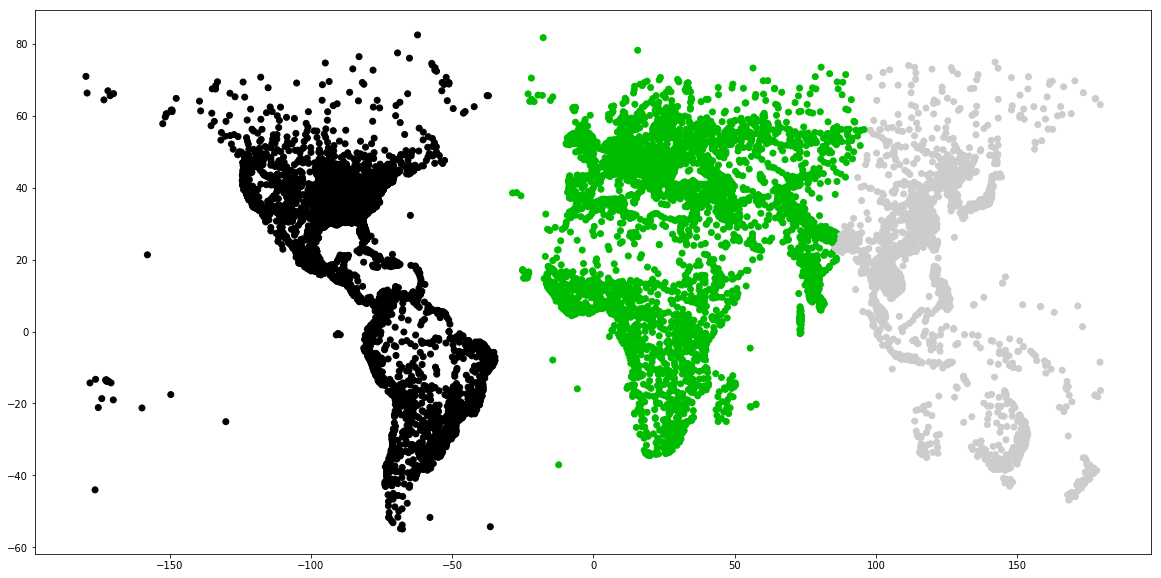

In [116]:
ward = AgglomerativeClustering(n_clusters=3, connectivity=A,linkage='ward').fit(X)
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 1],X[:, 0], c=ward.labels_, cmap=plt.cm.nipy_spectral)
    
plt.show()
 